# Non Cartesian online reconstruction

In [48]:
%cd /home/pac/gits/phd/mri-online/

/home/pac/gits/phd/mri-online


In [49]:
import os
import time
import numpy as np
import copy
import matplotlib.pyplot as plt
import scipy as sp
from mri.operators import FFT,WaveletN, OWL, NonCartesianFFT
from mri.reconstructors import CalibrationlessReconstructor
from modopt.opt.linear import Identity
from modopt.opt.proximity import GroupLASSO, IdentityProx
from online.operators.proximity import LASSO
from online.generators import Column2DKspaceGenerator,  DataOnlyKspaceGenerator, KspaceGenerator, PartialColumn2DKspaceGenerator
from online.reconstructors import OnlineReconstructor
from online.operators.fourier import ColumnFFT
from project_utils import implot, load_data, create_cartesian_metrics
from online.metrics import ssos, psnr_ssos,ssim_ssos,mse_ssos

plt.rcParams['axes.formatter.useoffset'] = False

plt.style.use({'figure.facecolor':'white'})

In [50]:
def plot_metric(results, name, *args, log=False, ax=None,**kwargs):
    if ax == None:
        ax = plt.gca()
    if log:
        ax.semilogy(results['metrics'][name]['index'], results['metrics'][name]['values'],*args,**kwargs,label=name)
    else:
        ax.plot(results['metrics'][name]['index'], results['metrics'][name]['values'],*args, **kwargs,label=name)


In [51]:
DATA_DIR = "data/"
N_JOBS = -1
results = dict()


coil_real, real_img, mask_loc, final_mask = load_data(DATA_DIR, 2, monocoil=False,fourier=False)
square_mask= np.zeros(real_img.shape)
real_img_size = real_img.shape
img_size = [min(real_img.shape)]*2
square_mask[real_img_size[0] // 2 - img_size[0] // 2:real_img_size[0] // 2 + img_size[0] // 2,
            real_img_size[1] // 2 - img_size[1] // 2:real_img_size[1] // 2 + img_size[1] // 2] = 1


trajectories = sp.io.loadmat('data/NCTrajectories.mat')

N_COILS = coil_real.shape[0] if coil_real.ndim == 3 else 1

# Offline reconstruction

In [52]:
print(trajectories)

fourier_sparkling = NonCartesianFFT(
    trajectories['spiral'],
    shape=coil_real.shape[-2:],
    n_coils=N_COILS,
    implementation='cpu',
    density_comp=trajectories['spiral_w'],
)


# Wavelets coefficients for each coils
linear_op = WaveletN("sym8", nb_scale=4, n_coils=N_COILS, n_jobs=-1)
# initialisation of wavelet transform
linear_op.op(np.zeros_like(coil_real))

# Regularizer definition
if N_COILS ==1:
    GL_op = LASSO(weights=1e-6)
else:
    GL_op = GroupLASSO(weights=2e-6)

OWL_op = OWL(alpha=1e-05,
             beta=1e-12,
             bands_shape=linear_op.coeffs_shape,
             mode='band_based',
             n_coils=N_COILS,
             n_jobs=N_JOBS)


prox_op = GL_op
cost_op_kwargs={'cost_interval':1}
solver = CalibrationlessReconstructor(
        fourier_sparkling,
        linear_op=linear_op,
        regularizer_op=prox_op,
        gradient_formulation="synthesis",
        verbose=0)

metrics = {'psnr': {'metric': lambda test, ref, mask: psnr_ssos(test,ref),
                        'mapping': {'x_new': 'test'},
                        'early_stopping': False,
                        'cst_kwargs': {'ref': real_img,
                                       'mask': square_mask},
                        },
          'ssim': {'metric': lambda test, ref,mask: ssim_ssos(test,ref),
                        'mapping': {'x_new': 'test'},
                        'early_stopping': False,
                        'cst_kwargs': {'ref': real_img,
                                       'mask': square_mask},
                        }}
xf_condat, cost, metric_results_condatvu= solver.reconstruct(fourier_sparkling.op(coil_real),
                                                             optimization_alg='pogm',
                                                             metrics=metrics,
                                                             metric_call_period=1,num_iterations=200
                                                        )


metric_results_condatvu['cost'] = {'index':np.arange(0,len(cost),cost_op_kwargs['cost_interval']),
                          'values':np.array(cost)}


{'__header__': b'MATLAB 5.0 MAT-file Platform: posix, Created on: Thu Jan 14 11:26:19 2021', '__version__': '1.0', '__globals__': [], 'sparkling': array([[1252.4834    ,  -61.4806    ],
       [1252.48421618,  -60.62930948],
       [1252.48603035,  -58.9266961 ],
       ...,
       [1254.15303718, -351.0389074 ],
       [1255.53146626, -353.18946544],
       [1256.45755514, -354.61859956]]), 'spiral': array([[491.5367    , 410.1573    ],
       [495.05180309, 405.47828531],
       [498.52336625, 400.76812542],
       ...,
       [571.95514333, 285.15217635],
       [569.56735735, 290.4918688 ],
       [567.13038886, 295.81040056]]), 'spiral_w': array([[0.08877814, 0.08663167, 0.08163019, ..., 0.07895025, 0.07869991,
        0.07881521]]), 'sparkling_w': array([[0.04282011, 0.02180997, 0.01146285, ..., 0.00845385, 0.01869698,
        0.04187083]])}


/home/pac/gits/phd/pysap-mri/mri/operators/fourier/non_cartesian.py:104: UserWarning: Samples will be normalized between [-0.5; 0.5[
  warnings.warn("Samples will be normalized between [-0.5; 0.5[")
/home/pac/gits/phd/pysap-mri/mri/operators/fourier/utils.py:106: UserWarning: Frequency equal to 0.5 will be put in -0.5
  warnings.warn("Frequency equal to 0.5 will be put in -0.5")
100% (200 of 200) |######################| Elapsed Time: 0:06:57 Time:  0:06:57


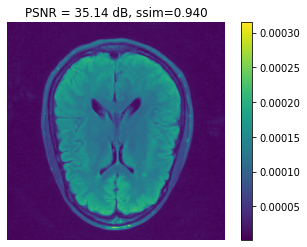

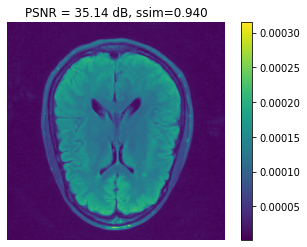

In [53]:
psnr = psnr_ssos(xf_condat,real_img,mask=square_mask)
ssim = ssim_ssos(xf_condat,real_img,mask=square_mask)
implot(ssos(xf_condat),title=f"PSNR = {psnr:.2f} dB, ssim={ssim:.3f}",mask=square_mask, colorbar=True)


# Type I reconstruction

# Type II reconstruction

In [54]:
full_k, real_img, mask_loc, final_mask = load_data(DATA_DIR, 2, monocoil=False)
final_k = np.squeeze(full_k * final_mask[np.newaxis])

line_kspace_gen = DataOnlyKspaceGenerator(full_kspace=final_k, mask_cols=mask_loc)
kspace_gen = PartialColumn2DKspaceGenerator(full_kspace=final_k, mask_cols=mask_loc)

K_DIM = line_kspace_gen.shape[-2:]
N_COILS = line_kspace_gen.shape[0] if full_k.ndim == 3 else 1
#line_fourier_op = ColumnFFT(shape=K_DIM, mask=final_mask, n_coils=N_COILS)
line_fourier_op = ColumnFFT(shape=K_DIM, n_coils=N_COILS)
fourier_op = FFT(shape=K_DIM,n_coils=N_COILS, mask=final_mask)


In [55]:
linear_op = WaveletN("sym8", nb_scale=4, n_coils=N_COILS, n_jobs=N_JOBS)
# initialisation of wavelet transform
linear_op.op(np.zeros_like(final_k))

# Regularizer definition
# Regularizer definition
if N_COILS ==1:
    GL_op = LASSO(weights=2e-6)
else:
    GL_op = GroupLASSO(weights=2e-6)

OWL_op = OWL(alpha=1e-05,
             beta=1e-12,
             bands_shape=linear_op.coeffs_shape,
             mode='band_based',
             n_coils=N_COILS,
             n_jobs=N_JOBS)
cost_op_kwargs = {'cost_interval': 1}

  1%|▏         | 1/80 [00:00<00:10,  7.43it/s]

vanilla


100%|██████████| 80/80 [00:10<00:00,  7.76it/s]


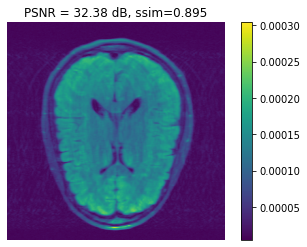

In [56]:
online_pb = OnlineReconstructor(line_fourier_op,
                                Identity(),
                                regularizer_op=IdentityProx(),
#                                 linear_op,
#                                 regularizer_op=OWL_op,
                                opt='vanilla',
                                verbose=0)

metrics_config = create_cartesian_metrics(online_pb, real_img, final_mask, final_k)
metrics_config['metrics']['grad'] = {'metric': lambda x,y: np.sqrt(np.sum(np.square(abs(y*x)))),
                               'mapping': {'dir_grad': 'x',
                                           'speed_grad':'y'},
                               'early_stopping': False,
                               'cst_kwargs': dict(),
                               }

# metrics_config['metrics'].pop('ssim')
# metrics_config['metrics'].pop('psnr')

results = online_pb.reconstruct(line_kspace_gen,
                                eta=1.,
                                beta=1.,
#                                 eta_update= lambda eta, idx: eta*1.001,
                       #         **metrics_config,
                                epsilon=1e-8,
                                nb_run=1,
                                epoch_size=1,
                                )
x=ssos(results['x_final'])

psnr = psnr_ssos(x,real_img,mask=square_mask)
ssim = ssim_ssos(x,real_img,mask=square_mask)
implot(x,title=f"PSNR = {psnr:.2f} dB, ssim={ssim:.3f}",mask=square_mask, colorbar=True);
